In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import integrate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [8]:
area_colors = {
    'MO': (0/255, 0/255, 0/255), # [31, 157, 90] 'blue'
    'ACA': (204/255, 121/255, 167/255), # [64, 166, 102] 'deepskyblue'
    'SS': (240/255, 228/255, 66/255), # [24, 128, 100] 'blueviolet'
    'VIS': (0/255, 158/255, 115/255), # [8, 133, 140] 'green'
    'MO-TH': (230/255, 159/255, 0/255), # [255, 112, 128] 'steelblue'
#     'VIS-TH': 'olivedrab'
}

In [9]:
# state_colors = {
#     'awake': (120/255, 156/255, 74/255),
#     'anesthetized': (130/255, 122/255, 163/255),
#     'recovery': (93/255, 167/255, 229/255)
# }
stcolors = {
    'resting': 'royalblue',
    'running': 'seagreen',
    'anesthetized': 'indianred',
}
stshapes = {
    'resting': 'o',
    'running': 's',
    'anesthetized': '^',
}

#### Functions

In [10]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='stationary'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [11]:
def get_zFR(trig_FR, FRtime):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
    baseline_avg = np.mean(trig_FR[FRtime < 0, :], axis=0)
    baseline_std = np.std(trig_FR[FRtime < 0, :], axis=0)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[:, nonzero_inds] = (trig_FR[:, nonzero_inds] - baseline_avg[None, nonzero_inds]) / baseline_std[None, nonzero_inds]
    
    return trig_Z

## Load subjects from file

In [12]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [13]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

## Choose example subject

In [14]:
group = 'MOs_deep'
mouse_num = '571619'

mdata = multi_sub_dict[group][mouse_num]
mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')

Experiment type: electrical stimulation


In [15]:
## Parameters ##
ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']
all_states = ['resting', 'running', 'anesthetized']
time_bin = 0.0001 # size of time bins (s)
sigmalong = 25

In [16]:
EEG_traces = {}
unref_EEG_traces = {}
LFP_traces = {}
unit_traces = {}

## Load unit info ##
fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
        all_unit_event_spikes = pickle.load(unit_file)
else:
    print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
    
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
)].squeeze()
try:
    bad_chs = mdata['bad_chs']
except KeyError:
    badchstr = exp_meta['EEG bad_channels'].replace(' ','')
    bad_chs = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_chs.append(int(char))
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)

## Load stim log (includes running speed now) ##
stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
event_window = all_unit_event_spikes['event_window']
bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2

## Load EEG traces ##
all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
mdata['good_chs'] = GOOD_CHS

## Load LFP info and traces ##
with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
    LFPinfo = json.load(info_file)
LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
mdata['LFPinfo'] = LFPinfo

## Loop through regions to get units and LFP ##
reg_unit_info = {}
reg_allLFPtraces = {}
for region in areas_of_interest.keys():
    if region in LFPinfo.keys():
        reg_allLFPtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
    if region in ctx_regions:
        regdf = unit_info[(unit_info['cell_type'] == 'RS') & (unit_info['parent'] == region)]
    else:
        regdf = unit_info[unit_info['parent'] == region]
    if len(regdf) > 5:
        reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)

## Get event inds ##
all_event_inds = {}
for leveli, parami in zip(current_levels, currents_list):
    all_event_inds[leveli] = {}
    for statei in test_states:
        sweeps = mdata['states'][statei]
        if not sweeps:
            continue
        state_events = []
        for sweepi in sweeps:
            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
            if len(events) == 0:
                continue
            state_events.append(events)
        all_event_inds[leveli][statei] = np.concatenate(state_events)

for leveli, states_event_times in all_event_inds.items():
    EEG_traces[leveli] = {}
    unref_EEG_traces[leveli] = {}
    LFP_traces[leveli] = {}
    unit_traces[leveli] = {}
    for statei, event_inds in states_event_times.items():
        LFP_traces[leveli][statei] = {}
        unit_traces[leveli][statei] = {}
        ## Get evoked EEG traces ##
        event_traces = all_EEG_traces[:, :, event_inds]
        unref_EEG_traces[leveli][statei] = [EEG_event_timestamps, event_traces]
        comavg_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
        EEG_traces[leveli][statei] = [EEG_event_timestamps, comavg_traces]
        
        for region in areas_of_interest.keys():
            ## Get evoked LFP traces ##
            if region in reg_allLFPtraces.keys():
                LFP_traces[leveli][statei][region] = [LFP_event_ts, reg_allLFPtraces[region][:, :, event_inds]]

            
            if region in reg_unit_info.keys():
                
                ## Get population event spike times ##
                regi_popsdf_l = np.zeros((len(timex), len(event_inds)), dtype=float) * np.nan
                for ei, eventi in enumerate(event_inds):
                    event_spikes = []
                    for ii, unitrow in reg_unit_info[region].iterrows():
                        event_spikes.append(all_unit_event_spikes['event_spikes'][unitrow.unit_id][eventi])
                    spcounts, edges = np.histogram(np.sort(np.concatenate(event_spikes)), bins)
                    regi_popsdf_l[:, ei] = (
                        ndimage.gaussian_filter(spcounts, sigma=sigmalong, output=float) / 
                        (time_bin * len(reg_unit_info[region]))
                    )
                unit_traces[leveli][statei][region] = [timex, regi_popsdf_l]
                
                ## Get unit z-score ##
#                 unit_firing_rates = np.zeros((len(timex), len(reg_unit_info[region])), dtype=float) * np.nan
#                 for ii, unitrow in reg_unit_info[region].iterrows():
#                     unit_event_spikes = [
#                         all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
#                     unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
#                     unit_firing_rates[:, ii] = unit_event_counts / (time_bin * len(event_inds))
#                 unit_traces[leveli][statei][region] = [timex, unit_firing_rates]

### After each subject, delete common variables ###
del all_EEG_traces, EEG_event_timestamps
del reg_allLFPtraces, LFP_event_ts, LFPinfo
del unit_info, all_unit_event_spikes, reg_unit_info

### Plot ERPs

<IPython.core.display.Javascript object>


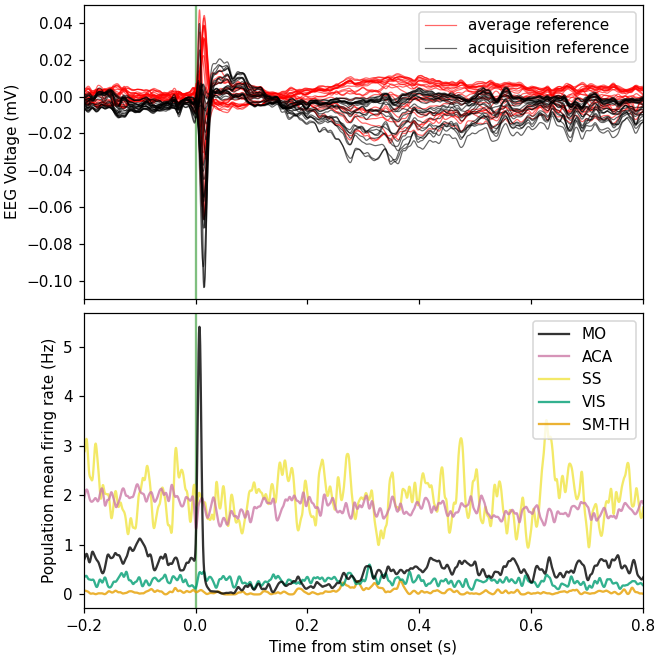

In [32]:
plot_stim = 'medium'
plot_state = 'anesthetized'
plotregions = ['MO-TH', 'VIS', 'SS', 'ACA', 'MO']

plwin = [-0.2, 0.8]
eeg_ylim = [-0.11, 0.05]

fig, axs = plt.subplots(2, 1, figsize=(6,6), constrained_layout=True, sharex=True)

eegtime = EEG_traces[plot_stim][plot_state][0]
comavg_traces = np.mean(EEG_traces[plot_stim][plot_state][1], axis=2)
unref_traces = np.mean(unref_EEG_traces[plot_stim][plot_state][1], axis=2)
axs[0].axvline(0, color='g', alpha=0.5)
axs[0].plot(eegtime, comavg_traces[:, GOOD_CHS] / 1E3, color='r', linewidth=0.8, alpha=0.6)
axs[0].plot(eegtime, unref_traces[:, GOOD_CHS] / 1E3, color='k', linewidth=0.8, alpha=0.6)
axs[0].set_xlim(plwin)
axs[0].set_ylim(eeg_ylim)
axs[0].set_ylabel('EEG Voltage (mV)')
custom_leg = [
    Line2D([0], [0], color='r', linewidth=0.8, alpha=0.6),
    Line2D([0], [0], color='k', linewidth=0.8, alpha=0.6),
]
axs[0].legend(custom_leg, ['average reference', 'acquisition reference'], loc='upper right')

axs[1].axvline(0, color='g', alpha=0.5)
for region in plotregions:
    utime = unit_traces[plot_stim][plot_state][region][0]
    utraces = unit_traces[plot_stim][plot_state][region][1]
    axs[1].plot(utime, np.mean(utraces, axis=1), color=area_colors[region], linewidth=1.5, alpha=0.8, label=region)
axs[1].set_ylabel('Population mean firing rate (Hz)')
axs[1].set_xlabel('Time from stim onset (s)')
handles, labels = plt.gca().get_legend_handles_labels()
axs[1].legend(handles[::-1], ['MO', 'ACA', 'SS', 'VIS', 'SM-TH'], loc='upper right')

## Save ##
figname = 'EEG_iso_refcomp_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

<IPython.core.display.Javascript object>


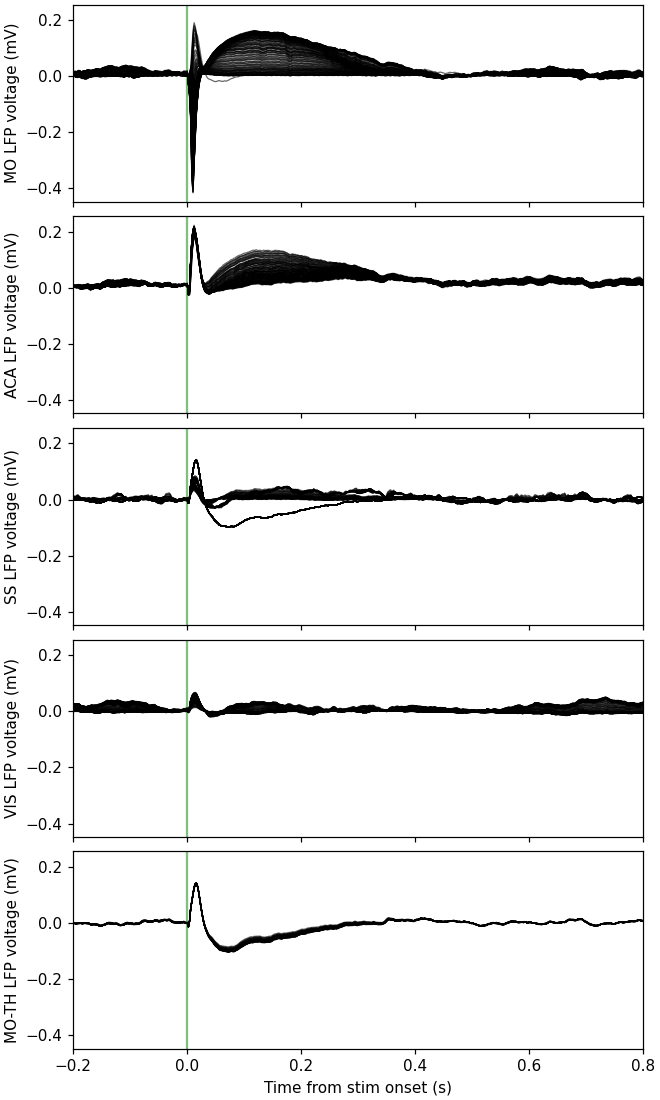

In [35]:
## Plot LFP ##
plot_stim = 'medium'
plot_state = 'anesthetized'
plotregions = ['MO', 'ACA', 'SS', 'VIS', 'MO-TH']

plwin = [-0.2, 0.8]
# eeg_ylim = [-0.11, 0.05]

fig, axs = plt.subplots(len(plotregions), 1, figsize=(6,10), constrained_layout=True, sharex=True, sharey=True)

for ax, region in zip(axs, plotregions):
    ltime = LFP_traces[plot_stim][plot_state][region][0]
    lfptraces = np.mean(LFP_traces[plot_stim][plot_state][region][1], axis=2) * 1E-3
    ax.axvline(0, color='g', alpha=0.5)
    ax.plot(ltime, lfptraces, color='k', linewidth=0.8, alpha=0.6)
    ax.set_ylabel('{} LFP voltage (mV)'.format(region))
ax.set_xlabel('Time from stim onset (s)')
ax.set_xlim(plwin)

## Save ##
figname = 'LFP_iso_refcomp_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)